Important Libraries

In [1]:
# Task 4
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
# Setting plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Loading and inspecting datasets
schema = pd.read_csv('SurveySchema (1).csv')
free_form = pd.read_csv('freeFormResponses.csv')
main_df = pd.read_csv('multipleChoiceResponses.csv', low_memory=False)  # Skiprows=1
print("Main Dataset Info:")
print(main_df.info())

/tmp/ipython-input-327539600.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  free_form = pd.read_csv('freeFormResponses.csv')


Main Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23860 entries, 0 to 23859
Columns: 395 entries, Time from Start to Finish (seconds) to Q50_OTHER_TEXT
dtypes: object(395)
memory usage: 71.9+ MB
None


In [4]:
# Checking Missing Values
print("\nMissing Values in Main Dataset:")
print(main_df.isnull().sum())


Missing Values in Main Dataset:
Time from Start to Finish (seconds)        0
Q1                                         0
Q1_OTHER_TEXT                              0
Q2                                         0
Q3                                         0
                                       ...  
Q50_Part_5                             20290
Q50_Part_6                             22800
Q50_Part_7                             21359
Q50_Part_8                             23339
Q50_OTHER_TEXT                             0
Length: 395, dtype: int64


In [5]:
# Clean the dataset
df_clean = main_df.copy()
df_clean.drop_duplicates(inplace=True)

In [6]:
# Drop high-missing columns (>70% missing based on schema)
df_clean.dropna(thresh=len(df_clean)*0.3, axis=1, inplace=True)

In [7]:
# Impute missing values
for col in ['Q1', 'Q3', 'Q6']:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Convert categorical ranges to numerical representations for Q8 and Q9
# Using a simple mapping to the lower bound of the range for approximation
q8_mapping = {
    '0-1': 0.5, '1-2': 1.5, '2-3': 2.5, '3-4': 3.5, '4-5': 4.5,
    '5-10': 7.5, '10-15': 12.5, '15-20': 17.5, '20-25': 22.5, '25-30': 27.5,
    '30 +': 35
}

q9_mapping = {
    '0-10,000': 5000, '10-20,000': 15000, '20-30,000': 25000, '30-40,000': 35000,
    '40-50,000': 45000, '50-60,000': 55000, '60-70,000': 65000, '70-80,000': 75000,
    '80-90,000': 85000, '90-100,000': 95000, '100-125,000': 112500,
    '125-150,000': 137500, '150-200,000': 175000, '200-250,000': 225000,
    '250-300,000': 275000, '300-500,000': 400000, '500,000+': 600000
}

df_clean['Q8_numeric'] = df_clean['Q8'].map(q8_mapping)
df_clean['Q9_numeric'] = df_clean['Q9'].map(q9_mapping)


for col in ['Q8_numeric', 'Q9_numeric']:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

/tmp/ipython-input-4204065025.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
/tmp/ipython-input-4204065025.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [8]:
# Handle multi-select (e.g.Q7 Languages)
languages_cols = [col for col in df_clean.columns if 'Q7_Part_' in col]
df_clean['Languages'] = df_clean[languages_cols].apply(lambda x: ', '.join(x.dropna()), axis=1)

In [9]:
# Standardize text (e.g. country)
df_clean['Q3'] = df_clean['Q3'].str.lower()

In [10]:
# Integrating free-form "Other" responses (e.g.Q1)
df_clean['Q1_OTHER'] = free_form['Q1_OTHER_TEXT'].fillna('None')
df_clean.loc[df_clean['Q1'].isna(), 'Q1'] = df_clean['Q1_OTHER']

In [11]:
# Encode categorical variables
le = LabelEncoder()
# Label encode ordinal
df_clean['Q2_encoded'] = le.fit_transform(df_clean['Q2'].fillna('Unknown'))
df_clean['Q4_encoded'] = le.fit_transform(df_clean['Q4'].fillna('Unknown'))

In [12]:
# One-hot encode nominal
job_role_dummies = pd.get_dummies(df_clean['Q6'], prefix='Role')
country_dummies = pd.get_dummies(df_clean['Q3'], prefix='Country')
df_clean = pd.concat([df_clean, job_role_dummies, country_dummies], axis=1)
# Binary for multi-select (e.g. Python from Q16)
df_clean['Python'] = df_clean['Q16_Part_1'].notnull().astype(int)

In [13]:
# Replace the text placeholder '-1' with a standard Not a Number (NaN) value.
df_clean.replace('-1', np.nan, inplace=True)

In [14]:
df_clean.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Country_sweden,Country_switzerland,Country_thailand,Country_tunisia,Country_turkey,Country_ukraine,Country_united kingdom of great britain and northern ireland,Country_united states of america,Country_viet nam,Python
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,in which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,False,False,False,False,False,False,False,False,False,1
1,710,Female,NaN,45-49,united states of america,Doctoral degree,Other,Consultant,NaN,Other,...,False,False,False,False,False,False,False,True,False,0
2,434,Male,NaN,30-34,indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,False,False,False,False,False,False,False,False,False,0
3,718,Female,NaN,30-34,united states of america,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,NaN,I am a student,...,False,False,False,False,False,False,False,True,False,0
4,621,Male,NaN,35-39,united states of america,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,NaN,NaN,...,False,False,False,False,False,False,False,True,False,1


In [15]:
# Extracting insights
# Insight 1: Top job roles
top_roles = df_clean['Q6'].value_counts().head(5)
print("\nTop 5 Job Roles:")
print(top_roles)


Top 5 Job Roles:
Q6
Student              6200
Data Scientist       4137
Software Engineer    3130
Data Analyst         1922
Other                1322
Name: count, dtype: int64


In [ ]:
# Insight 2: Top programming languages
lang_count = df_clean['Languages'].str.split(', ').explode().value_counts().head(5)
print("\nTop 5 Programming Languages:")
print(lang_count)


Top 5 Programming Languages:
Languages
    23848
Name: count, dtype: int64


In [16]:
# Insight 3: What are the most popular programming languages?
print("\nMost Popular Programming Languages:")
language_counts = df_clean['Q16_Part_1'].value_counts()
print(language_counts)


Most Popular Programming Languages:
Q16_Part_1
Python                                                                                                          15711
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python        1
Name: count, dtype: int64


In [17]:
# Insight 4: Education by role
edu_by_role = df_clean.groupby('Q6')['Q4'].value_counts(normalize=True).unstack().head()
print("\nEducation Distribution by Role (Top Roles):")
print(edu_by_role)


Education Distribution by Role (Top Roles):
Q4                     Bachelor’s degree  Doctoral degree  \
Q6                                                          
Business Analyst                0.326425         0.034974   
Chief Officer                   0.202778         0.180556   
Consultant                      0.270064         0.122293   
DBA/Database Engineer           0.386207         0.062069   
Data Analyst                    0.338189         0.065036   

Q4                     I prefer not to answer  Master’s degree  \
Q6                                                               
Business Analyst                     0.011658         0.536269   
Chief Officer                        0.005556         0.508333   
Consultant                           0.014013         0.514650   
DBA/Database Engineer                0.027586         0.386207   
Data Analyst                         0.013007         0.515609   

Q4                     No formal education past high school  \
Q

In [18]:
# Insight 5: Gender distribution
gender_dist = df_clean['Q1'].value_counts(normalize=True)
print("\nGender Distribution:")
print(gender_dist)


Gender Distribution:
Q1
Male                                      0.814240
Female                                    0.168148
Prefer not to say                         0.014257
Prefer to self-describe                   0.003313
What is your gender? - Selected Choice    0.000042
Name: proportion, dtype: float64


In [19]:
# Insight 6: ML experience by industry
ml_exp_by_industry = df_clean.groupby('Q7')['Q8'].value_counts(normalize=True).unstack().head(5)
print("\nML Experience by Industry (Top 5 Industries):")
print(ml_exp_by_industry)


ML Experience by Industry (Top 5 Industries):
Q8                                0-1       1-2     10-15     15-20       2-3  \
Q7                                                                              
Academics/Education          0.229970  0.181751  0.078264  0.043769  0.120920   
Accounting/Finance           0.253173  0.177715  0.086037  0.038787  0.129760   
Broadcasting/Communications  0.205405  0.175676  0.086486  0.037838  0.127027   
Computers/Technology         0.254017  0.188662  0.081423  0.037732  0.115725   
Energy/Mining                0.224215  0.192825  0.091928  0.044843  0.125561   

Q8                              20-25     25-30       3-4      30 +       4-5  \
Q7                                                                              
Academics/Education          0.027819  0.009644  0.084199  0.018917  0.075668   
Accounting/Finance           0.020451  0.005642  0.057828  0.007052  0.074753   
Broadcasting/Communications  0.016216       NaN  0.067568  0.

In [20]:
# Insight 7: What is the age distribution?
print("\nAge Distribution:")
age_counts = df_clean['Q2'].value_counts()
age_order = sorted(df_clean['Q2'].dropna().unique())
print(df_clean['Q2'].value_counts().reindex(age_order))


Age Distribution:
Q2
18-21                          3033
22-24                          5140
25-29                          6153
30-34                          3776
35-39                          2252
40-44                          1360
45-49                           858
50-54                           582
55-59                           328
60-69                           273
70-79                            53
80+                              39
What is your age (# years)?       1
Name: count, dtype: int64


In [21]:
#insight 8
# Analyze Python usage for each of the top roles
python_users_series = pd.Series(dtype=int)
for role in top_roles.index:
    # Filter the DataFrame for the current role
    df_role = df_clean[df_clean['Q6'] == role]

    # Count the number of respondents using Python in this role
    python_users_in_role = df_role['Q16_Part_1'].value_counts().get('Python', 0)

    # Store the count in the series
    python_users_series[role] = python_users_in_role

    print(f"\nRole: {role}")
    print(f"Number of Python users: {python_users_in_role}")


Role: Student
Number of Python users: 3272

Role: Data Scientist
Number of Python users: 3346

Role: Software Engineer
Number of Python users: 2152

Role: Data Analyst
Number of Python users: 1198

Role: Other
Number of Python users: 878


/tmp/ipython-input-80642592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_roles.index, y=top_roles.values, palette='viridis')


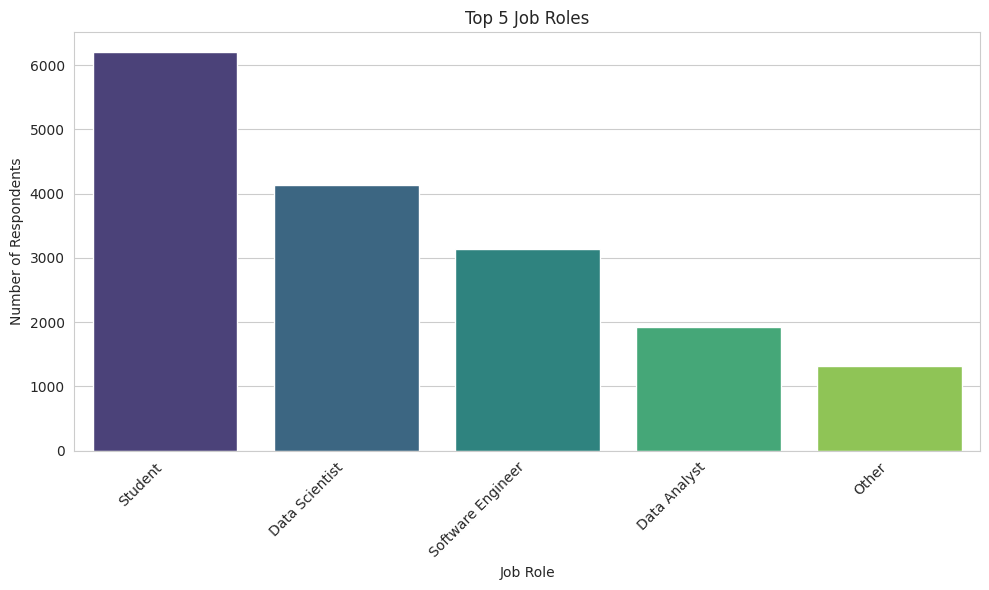

In [22]:
# Visualize the Top Roles
plt.figure(figsize=(10, 6))
sns.barplot(x=top_roles.index, y=top_roles.values, palette='viridis')
plt.title('Top 5 Job Roles')
plt.xlabel('Job Role')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2945231552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.head(10).values, y=language_counts.head(10).index, palette='viridis')


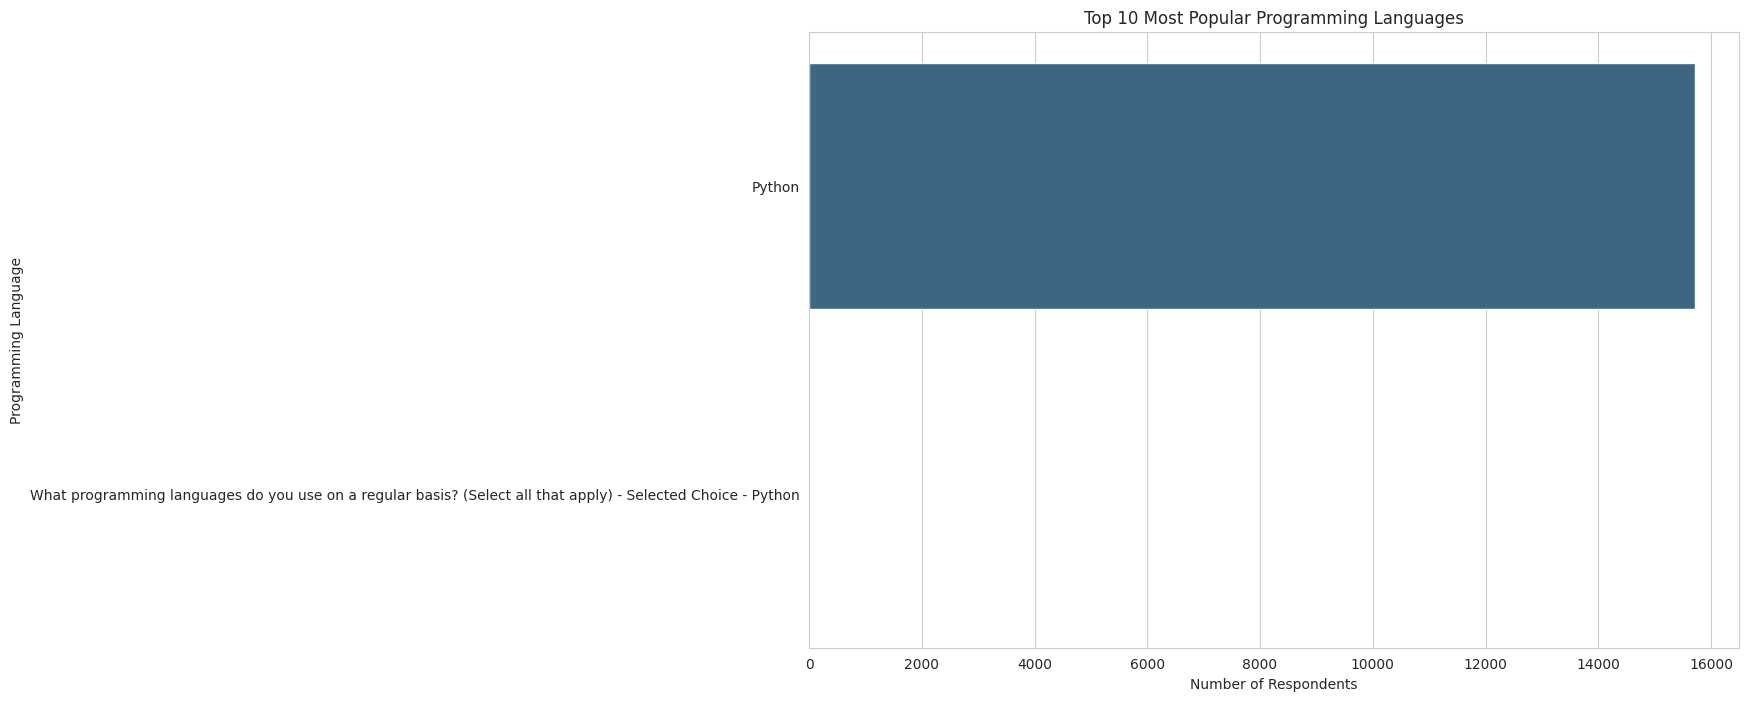

In [23]:
# Visualize the Top 10 Language
plt.figure(figsize=(12, 8))
sns.barplot(x=language_counts.head(10).values, y=language_counts.head(10).index, palette='viridis')
plt.title('Top 10 Most Popular Programming Languages')
plt.xlabel('Number of Respondents')
plt.ylabel('Programming Language')
plt.show()

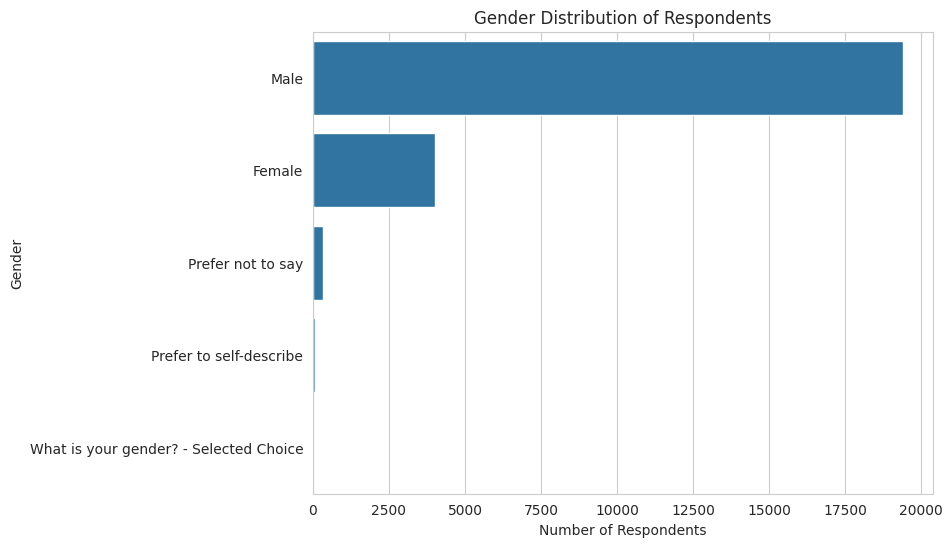

In [24]:
# Visualiz Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y=df_clean['Q1'], order=gender_dist.index)
plt.title('Gender Distribution of Respondents')
plt.xlabel('Number of Respondents')
plt.ylabel('Gender')
plt.show()

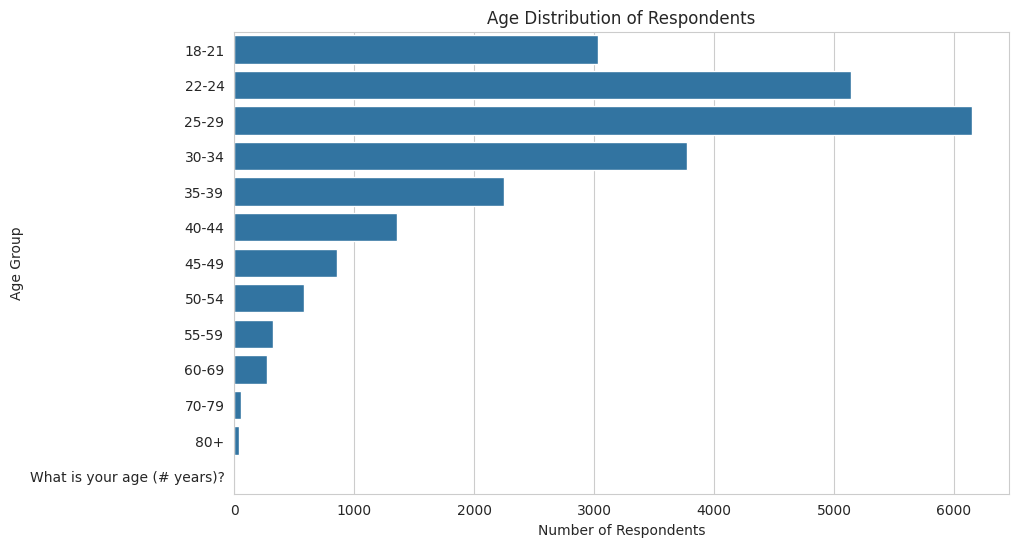

In [25]:
#Visualize Age Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, y='Q2', order=age_order)
plt.title('Age Distribution of Respondents')
plt.xlabel('Number of Respondents')
plt.ylabel('Age Group')
plt.show()

/tmp/ipython-input-3891071992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=python_users_series.values, y=python_users_series.index, palette='viridis')


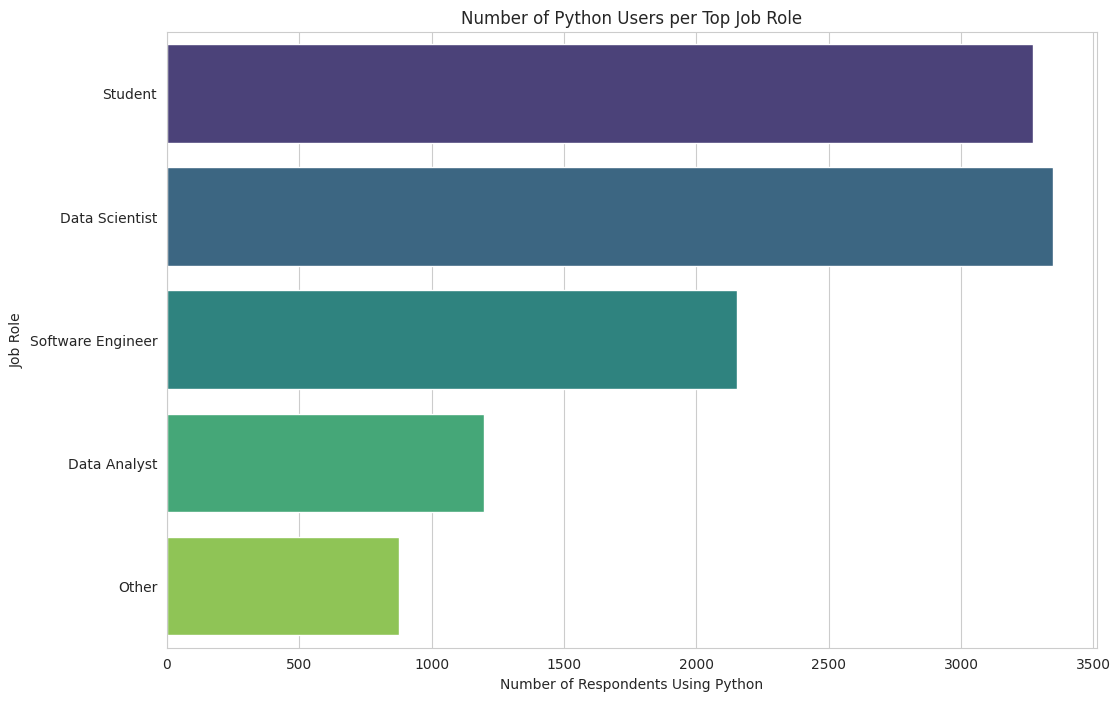

In [26]:
# Visualize the Python usage per role
plt.figure(figsize=(12, 8))
sns.barplot(x=python_users_series.values, y=python_users_series.index, palette='viridis')
plt.title('Number of Python Users per Top Job Role')
plt.xlabel('Number of Respondents Using Python')
plt.ylabel('Job Role')
plt.show()

/tmp/ipython-input-669475191.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


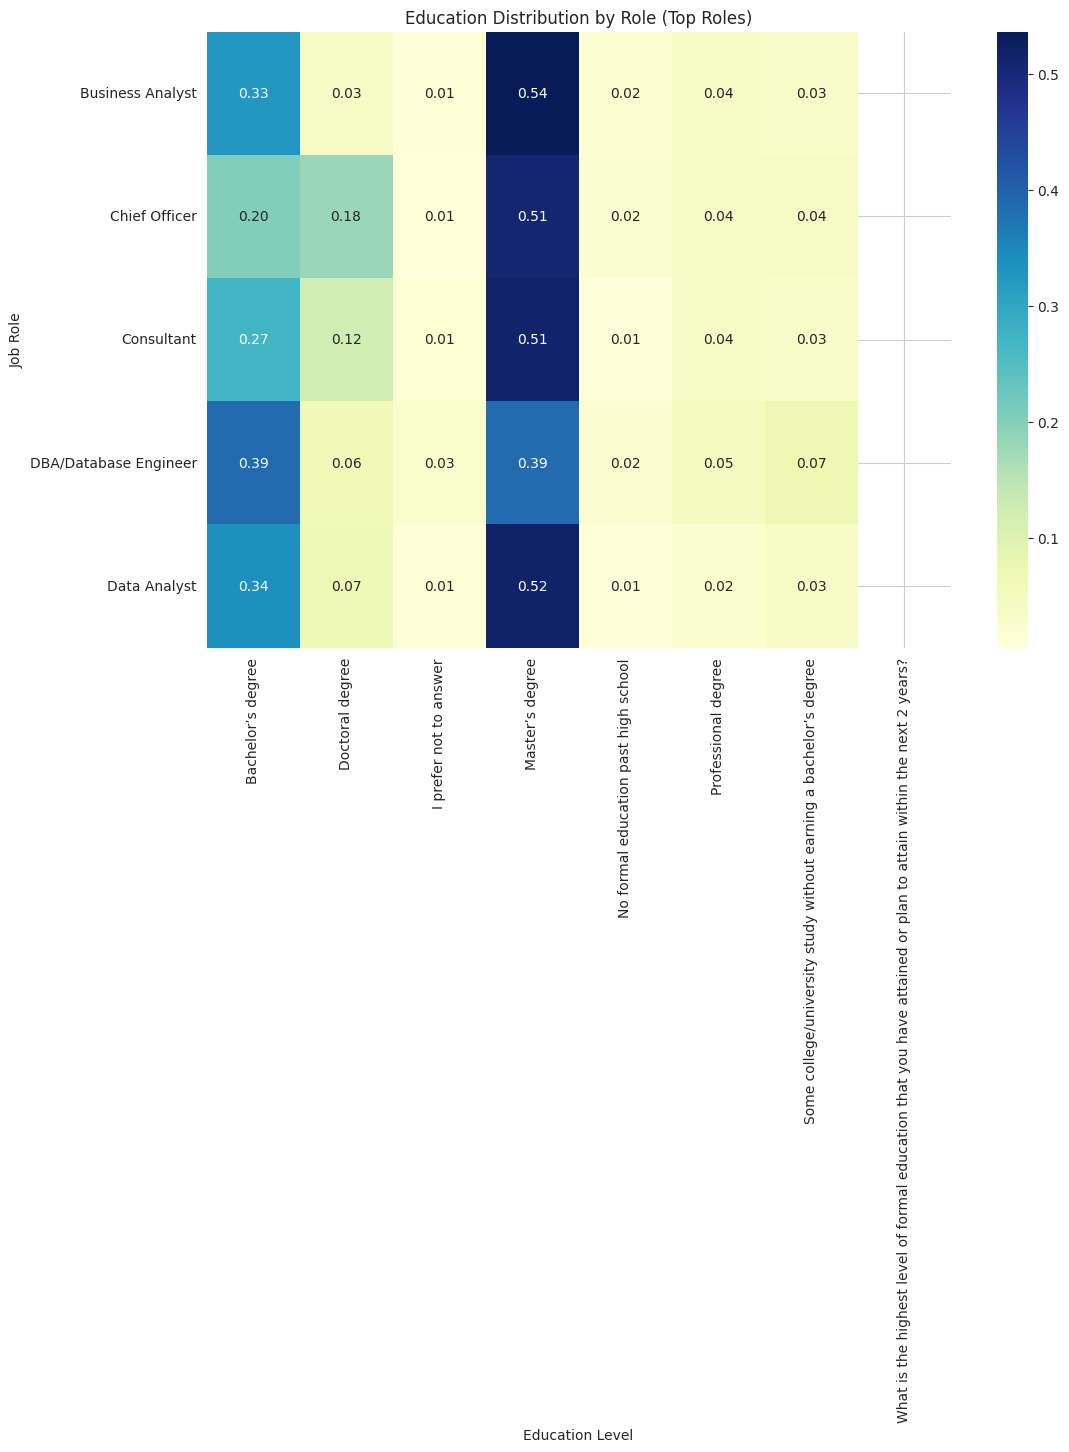

In [27]:
# Visualize Education by Role using a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(edu_by_role, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Education Distribution by Role (Top Roles)')
plt.xlabel('Education Level')
plt.ylabel('Job Role')
plt.tight_layout()
plt.show()

In [28]:
#Save cleaned data
df_clean.to_csv('cleaned_survey_2018.csv', index=False)
print("\nCleaned dataset saved as 'cleaned_survey_2018.csv'")
print("Dashboard saved as 'survey_insights_dashboard_2018.png'")


Cleaned dataset saved as 'cleaned_survey_2018.csv'
Dashboard saved as 'survey_insights_dashboard_2018.png'
